## A conversation with Andrew Ng
**Word Embedding** : for representing the semantics of a word
> Tensorflow에서 word embedding 기능 제공



## Introduction
**Embedding** : 특정 단어들과 그것과 연관된 단어들은 다차원 공간에서 벡터들로 군집화된다는 개념에서 나온 것
> ex. 특정 단어들은 '긍정' 방향을 향하고, 특정 단어들은 '부정' 방향을 향함

## The IMBD Dataset
텐서플로우의 데이터셋 라이브러리인 **TensorFlow Data Services (TFDS)**에는 다양한 데이터 셋들이 존재함 (image, audio, text 등)
> 그 중 text 데이터셋에 해당하는 **IMDB** ("**imdb_reviews**") : 긍정 or 부정으로 분류된 영화 리뷰 데이터들  
  
```py
import tensorflow_datasets as tfds 
# tfds : TensorFlow Data Services (라이브러리 명 : tensorflow_datasets)


## Looking into the details

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# !pip install -q tensorflow-datasets => 구글 코랩에는 이미 설치되어 있음!

#### [ cf. 2 methods of TensorFlow Datasets dataset loading ]
* 1. 
```py 
import tensorflow_datasets as tfds
tdds.load("imdb_reviews")
```
* 2. 
```py
import tensorflow as tf
tf.keras.datasets.imdb.load_data()
```

In [ ]:
import tensorflow_datasets as tfds

imdb, info = tfds.load("imdb_reviews", with_info = True, as_supervised = True) # imda data, metadata 반환 



import numpy as np

train_data, test_data = imdb['train'], imdb['test'] # imdb : train과 test set으로 나누어져 있음! (각 25000 씩)

training_sentences = []
training_labels = []

testing_sentences = []
training_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s, l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())

for s, l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

# 1 : 긍정 label
# 0 : 부정 label

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [ ]:
# tokenizing sentences

# set hyperparameters (to make easier to change)
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok) 
tokenizer.fit_on_texts(training_sentences)  
word_index = tokenizer.word_index  # training sentences로 만들어진 word_index
sequences = tokenizer.texts_to_sequences(training_sentences) 
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type) # padding and crop

testing_sentences = tokenizer.texts_to_sequences(testing_sentences) 
testing_padded = pad_sequences(testing_sequences, maxlen=max_length) 

In [ ]:
# define neural network ==> add Embedding!!

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), # 임베딩!! 텍스트 감정분석 핵심!!
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')                            
])

## How can we use vectors?
* 비슷한 의미의 단어들은 비슷한 벡터들로 할당됨 (함께 모임)
* 모델 학습 : 벡터와 그것의 label을 학습하는 것
> ==> **embedding**
* embedding 결과 : 2차원 배열 (문장의 길이, embedding 차원 수)
  
    
* Flatten() 대신 **GlobalAveragePooling1D()** 사용 :  벡터 요소들 전체의 평균들을 flatten
> 좀 더 느리게 학습되지만, 더 정확한 결과 도출



In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), # 임베딩!
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')                            
])

## More into the details

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


num_epochs = 10
model.fit(padded, # train_X
          training_labels_final, # train_Y
          epochs=num_epochs, # epochs
          validation_data=(testing_padded, testing_labels_final)) # val_set or callbacks

embedding 층의 학습 결과 확인 (weights)

In [ ]:
e = model.layeres[0]
weights = e.get_weights()[0] # embedding 층 : 0번째
print(weights.shape) # shape : (vocab_size, embedding_dim) ==> (10000, 16)

embedding 층의 weights.shape : (10000, 16)
> 즉, 말뭉치에 총 10000개의 단어들 존재, 16차원 배열로 embedding 작업 중!

In [ ]:
# reverse word index (키-값 순서 바꾸기) ==> to be able to plot it
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) 

In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
# 위에서 reverse한 dict 이용! (숫자 인덱스로 접근)
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n") # 메타 데이터 파일
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n") # 벡터 파일
out_v.close()
out_m.close()

### [ cf. word embedding? ]
* 워드 임베딩이란, 텍스트 내의 **단어들을 밀집 벡터(dense vector)로 만드는 것** 
> **워드 임베딩 <-> 원핫 인코딩**
* dense vector : 대부분의 값이 실수이고, 상대적으로 저차원인 벡터
> ex. [0.1 -1.2 0.8 0.2 1.8] : 상대적으로 저차원이며 실수값을 가짐
* sparse vector : 희소 벡터. 대부분의 값이 0인 벡터
> ex. [0 1 0 0 0 0 ... 중략 ... 0 0 0 0 0 0 0] : 차원이 굉장히 크면서 대부분의 값이 0, 1은 한개뿐 (원핫 벡터)

임베딩 벡터는 초기에는 **랜덤값**을 가지지만, 인공 신경망의 **가중치**가 학습되는 방법과 같은 방식으로 **값이 학습되며 변경**
* **Embedding()** : 단어를 밀집 벡터로 만드는 역할
* **정수 인코딩(indexing)**이 된 단어들을 입력으로 받아서 **임베딩(값 학습)**을 수행
* **Embedding Dimensions** : 한 단어당 학습될 벡터의 특징 개수 (ex. 16 : 한 단어당 16개의 특징(인자)들 갖고 학습됨)

## Remember the sarcasm dataset?
IMDB말고 sarcasm dataset을 위한 분류기 만들기 (약 27000 records)

In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# set hyper parameters
vocab_size = 10000
embedding_dim = 16 # 임베딩 후 벡터의 차원이 16차원 (1 x 16) ==> 한 단어당 16 특징씩 학습됨
max_length = 32
trunc_type = 'post'
padding_type =  'post'
oov_tok = '<OOV>' # out of voca
training_size = 20000 # 전체 27000개 중 20000개는 학습용, 7000개는 검증용

In [4]:
# download sarcasm dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-02-08 03:30:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2021-02-08 03:30:37 (157 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [6]:
# open downloaded dataset as an iterable
with open("/tmp/sarcasm.json", 'r') as f:
  datastore = json.load(f)

# separate into sentences and labels (array)
sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

## Building a classifier for the sarcasm dataset

In [7]:
# separate into training and test set (sentences, labels each)
training_sentences = sentences[0:training_size] # [0 : 20000]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [10]:
# make word_index and encode (sentences -> sequences), padding
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences) # encoding sentences (make word index!)

word_index = tokenizer.word_index # return word index

training_sequences = tokenizer.texts_to_sequences(training_sentences) # sentences -> sequences (integer array)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [17]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [18]:
# create and compile model 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')                             
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary() # 한 문장당 길이 32, 한 단어당 16차원의 벡터 ==> 따라서 32x16

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 32, 16)            160000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fit model (train)
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.5644 - accuracy: 0.7044 - val_loss: 0.3975 - val_accuracy: 0.8389
Epoch 2/30
625/625 - 2s - loss: 0.3111 - accuracy: 0.8771 - val_loss: 0.3421 - val_accuracy: 0.8544
Epoch 3/30
625/625 - 2s - loss: 0.2302 - accuracy: 0.9104 - val_loss: 0.3514 - val_accuracy: 0.8535
Epoch 4/30
625/625 - 2s - loss: 0.1858 - accuracy: 0.9294 - val_loss: 0.3666 - val_accuracy: 0.8544
Epoch 5/30
625/625 - 2s - loss: 0.1544 - accuracy: 0.9430 - val_loss: 0.4372 - val_accuracy: 0.8307
Epoch 6/30
625/625 - 2s - loss: 0.1291 - accuracy: 0.9541 - val_loss: 0.4331 - val_accuracy: 0.8450
Epoch 7/30
625/625 - 2s - loss: 0.1111 - accuracy: 0.9620 - val_loss: 0.4734 - val_accuracy: 0.8425
Epoch 8/30
625/625 - 2s - loss: 0.0935 - accuracy: 0.9688 - val_loss: 0.5195 - val_accuracy: 0.8392
Epoch 9/30
625/625 - 2s - loss: 0.0826 - accuracy: 0.9730 - val_loss: 0.5719 - val_accuracy: 0.8344
Epoch 10/30
625/625 - 2s - loss: 0.0710 - accuracy: 0.9769 - val_loss: 0.6235 - val_accuracy: 0.8305

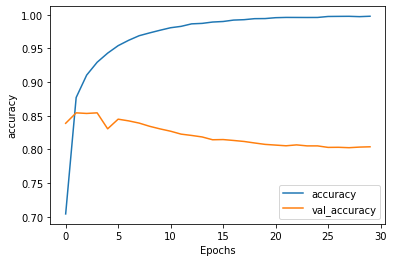

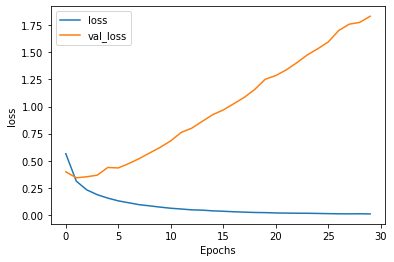

In [21]:
# plot results
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

위의 결과에서, val_loss는 오히려 커짐..! why?

## Let's talk about the loss function
**hyper parameter**들을 조정해가면서 차이 보기
> 이렇게 변수들을 위에 따로 지정한 후 **조정**해 가는 방식은 매우 유용!

In [1]:
vocab_size = 1000 # (was 10000) => 전체 단어 종류 개수 줄이고
embedding_dim = 16 
max_length = 16 # (was 32) => 문장의 길이 줄이기
trunc_type = 'post'
padding_type =  'post'
oov_tok = '<OOV>' 
training_size = 20000 

# 결과 : val_loss는 전보다 평평해져서 좋아지지만, accuracy는 별 차이 없음

In [ ]:
vocab_size = 1000 # (was 10000) => 전체 단어 종류 개수 줄이고
embedding_dim = 32 # (was 16) => 임베딩(벡터) 차원 늘리기 (단어 당 특징 수)
max_length = 16 # (was 32) => 문장의 길이 줄이기
trunc_type = 'post'
padding_type =  'post'
oov_tok = '<OOV>' 
training_size = 20000 

# 결과 : 별 차이 없음

## Pre-tokenized datasets
**단어들의 순서**가 text classification에서 매우 중요!

## Diving into the code (part1)

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

train_data, test_data = imdb['train'], imdb['test']

# access the sub words tokenizer
tokenizer = info.features['text'].encoder # import Tokenizer 안하고 info 이용해서 encode하여 tokenizer 생성


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWSKGRD/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWSKGRD/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteWSKGRD/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


## Diving into the code (part2)

In [3]:
print(tokenizer.subwords) # pre-trained sub-word tokenizer's sub words (한 단어도 sub로 더 쪼갬)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [4]:
# see how it encodes and decodes (ex)
sample_string = 'Tensorflow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string) # encde (Tokenizer의 fit_on_texts)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string) # decode
print('The original string : {}'.format(original_string))

Tokenized string is [6307, 2327, 2934, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string : Tensorflow, from basics to mastery


In [5]:
# see the tokens
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer.decode([ts]))) # ,(콤마)도 tokenized! / 대소문자도 구분

6307 ----> Ten
2327 ----> sor
2934 ----> flow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [6]:
# create model
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(), # flatten()시 error
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')                            
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


#### [ cf. GlobalAveragePooling1D() ]
Embedding() 다음에 GlobalAveragePooling1D()을 추가하면, **해당 문장의 모든 단어 벡터들의 평균 벡터**를 구함.   
 (각 sub word(단어)마다 embedding_dim 크기의 벡터로 존재! 그것들을 평균 냄)
> 따라서 **문장 단위로** 긍정, 부정 평가!

In [7]:
# not mandatory
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [9]:
# compile and fit (train) model
num_epochs = 10

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_dataset, # train_data -> train_dataset
                    epochs=num_epochs,
                    validation_data=test_dataset) # test_data -> test_dataset 으로 바꿔야 error clear

# train_data, test_data = imdb['train'], imdb['test']

Epoch 1/10
391/391 [==============================] - 13s 28ms/step - loss: 0.6872 - accuracy: 0.5565 - val_loss: 0.6085 - val_accuracy: 0.7550
Epoch 2/10
391/391 [==============================] - 11s 28ms/step - loss: 0.5420 - accuracy: 0.7893 - val_loss: 0.4173 - val_accuracy: 0.8477
Epoch 3/10
391/391 [==============================] - 11s 28ms/step - loss: 0.3628 - accuracy: 0.8729 - val_loss: 0.3513 - val_accuracy: 0.8570
Epoch 4/10
391/391 [==============================] - 11s 28ms/step - loss: 0.2847 - accuracy: 0.8964 - val_loss: 0.3322 - val_accuracy: 0.8644
Epoch 5/10
391/391 [==============================] - 11s 28ms/step - loss: 0.2533 - accuracy: 0.9104 - val_loss: 0.3115 - val_accuracy: 0.8772
Epoch 6/10
391/391 [==============================] - 11s 28ms/step - loss: 0.2239 - accuracy: 0.9205 - val_loss: 0.3050 - val_accuracy: 0.8820
Epoch 7/10
391/391 [==============================] - 11s 28ms/step - loss: 0.2060 - accuracy: 0.9289 - val_loss: 0.3088 - val_accuracy:

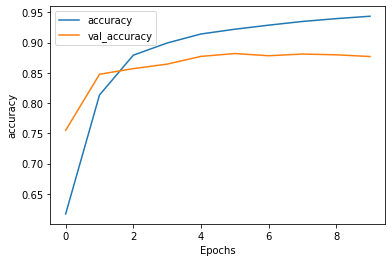

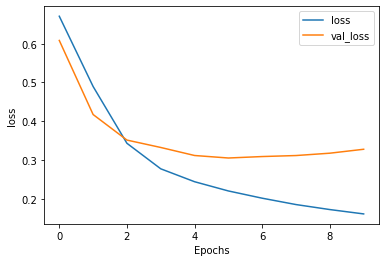

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

결론 : **sub words**는 그냥 그 자체들만으로는 의미가 없고, **의미를 갖는 sequence(순서)로 조합**할 때에만 의미가 있다!